# <center>Geometric Methods in Machine Learning<br/><br/>Poincaré Embeddings<br/><br/>Zakarya Ali et Samir Tanfous</center>

Nous étudions l'article [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/pdf/1705.08039.pdf) de Maximilian Nickel et Douwe Kiela.

## Prérequis
On fait l'import du code et des données nécessaires

In [ ]:
from collections import defaultdictnetwork
import os
import numpy as np
import csv
import random
import time
import pickle
import logger
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
wordnet_mammal_file = 'data/wordnet_mammal_hypernyms.tsv'

In [33]:
def load_wordnet(wordnet_path):
    network = {}
    with open(wordnet_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if not row[0]==row[1]:
                if row[0] in network:
                    network[row[0]].append(row[1])
                else:
                    network.update({row[0]:[row[1]]})
    return network

In [35]:
def poincare_dist(gamma): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return np.arccosh(gamma)

In [36]:
def compute_gamma(vec1, vec2):
    euclidean_dists = np.linalg.norm(vec1 - vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    alpha = 1-norm1**2
    beta = 1-norm2**2
    gamma = 1 + 2*euclidean_dists/(alpha*beta)
    return gamma

In [37]:
def deriv_poincare_theta(theta, x, gamma): 
    """Dérivée partielle par rapport à theta de la distance de Poincare (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1))*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2))*theta - x/(alpha))

In [69]:
def update(emb, error_, learning_rate):
    """Equation d'update (equation 5)"""
    update =  learning_rate*pow((1 - np.linalg.norm(emb)), 2)*error_/4
    emb = emb - update
    if (np.dot(emb, emb) >= 1):
        emb = emb/np.sqrt(np.dot(emb, emb)) - EPSILON
    return emb

In [68]:
def get_negative_candidates(network, vocab, vocab_weights, u, num_negs):
    """Retourne une liste de mots qui ne sont pas liés à celui donné en entrée"""
    negs = []
    while (len(negs) < num_negs):
        neg = np.random.choice(vocab, p=vocab_weights)
#         neg = random.choice(vocab)
        if not (neg in network[u] or u in network[neg] or neg == u): # neg ne doit pas etre lié à u et vice versa
            negs.append(neg)
    return negs

In [43]:
def initialize_embedding(network, embedding_size):
    """Comme dans l'article, on initialise la position des noeuds entre 0.001 et -0.001"""
    emb = {}
    gap = 1e-3
    for a in network:
        for b in network[a]:
            emb[b] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
        emb[a] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
    return emb

In [44]:
def get_vocabulary(network):
    vocab = list(emb.keys())
    vocab_weights = np.zeros(len(vocab))
    for key in network:
        for u in network[key]:
            vocab_weights[vocab.index(u)]+=1
    vocab_weights = vocab_weights / np.sum(vocab_weights)
    return vocab, vocab_weights

# 1. Entrainement

In [131]:
#Initialisation des variables
network = load_wordnet(wordnet_mammal_file)

embedding_size = 5 #dimension des vecteurs d'entrainement

#epochs
num_epochs = 250
#burn-in, nombre d'épochs
nb_burn_in = 10

#nombre de nodes negatives pour l'entrainement
num_negs = 20

#learning rate
lr = 1e-2
#learning rate pour le burn-in
learning_rate_burn_in = lr/10

EPSILON = 1e-5 # evite l'overflow

vocab, vocab_weights = get_vocabulary(network)

In [132]:
# random.shuffle(vocab)

# On ajoute les noeuds non connectés
for a in emb:
    if not a in network:
        network[a] = []
        
emb = initialize_embedding(network, embedding_size)# embedding of nodes of network

last_time = time.time()
for epoch in range(num_epochs+nb_burn_in):
    if epoch < nb_burn_in:
        learning_rate = learning_rate_burn_in
    else:
        learning_rate = lr
    for u in vocab:
        if not network[u]: # une node
            continue
        
        #traitement des positifs
#         positives = random.shuffle(network[u]) 
        v = random.choice(network[u]) 
#         gamma_u_positives = [] # distances entre nodes qui ne sont pas liées
#         dist_positives = [] # distances entre nodes qui ne sont pas liées
#         for v in positives:
        gamma_u_v = compute_gamma(emb[u], emb[v])
#             gamma_u_positives.append(gamma_u_v)
        dist_p_u_v = poincare_dist(gamma_u_v) # distance between the related nodes
#             dist_positives.append(dist_p_u_v)
        
        gamma_u_negs = [] # distances entre nodes qui ne sont pas liées
        dist_negs = [] # distances entre nodes qui ne sont pas liées
        negs = get_negative_candidates(network, vocab, vocab_weights, u, num_negs) 
        for neg in negs:
            gamma_u_neg = compute_gamma(emb[u], emb[neg])
            gamma_u_negs.append(gamma_u_neg)
            dist_neg = poincare_dist(gamma_u_neg)
            dist_negs.append(dist_neg)
                
        loss_den = 0.0
        
        # eqn6
        for dist_neg in dist_negs:
            loss_den += np.exp(-dist_neg)
#         loss = -dist_p_u_v - np.log(loss_den)
        
        # derivative of loss wrt positive relation [d(u, v)]
        der_negs = []
        # derivative of loss wrt negative relation [d(u, v')]
        for dist_neg in dist_negs:
            der_negs.append(np.exp(-1*dist_neg)/(loss_den))
        # derivative of loss wrt pos1
        der_p_u = deriv_poincare_theta(emb[u], emb[v], gamma_u_v)
        # derivative of loss wrt pos2
        der_p_v = deriv_poincare_theta(emb[v], emb[u], gamma_u_v)
        
        der_negs_final = []        
        for (der_neg, neg, gamma_u_neg) in list(zip(der_negs, negs, gamma_u_negs)):
            # derivative of loss wrt second element of the pair in neg
            der_neg1 = der_neg * deriv_poincare_theta(emb[neg], emb[u], gamma_u_neg)
            # derivative of loss wrt first element of the pair in neg
            der_neg0 = der_neg * deriv_poincare_theta(emb[u], emb[neg], gamma_u_neg)
            der_negs_final.append([der_neg0, der_neg1])
        
        # update embeddings now
        emb[u] = update(emb[u], der_p_u, learning_rate)
        emb[v] = update(emb[v], der_p_v, learning_rate)
        for (neg, der_neg) in list(zip(negs, der_negs_final)):
            emb[u] = update(emb[u], -1*der_neg[0], learning_rate)
            emb[neg] = update(emb[neg], -1*der_neg[1], learning_rate)
    print('Epoch #%d, temps d\'exécution: %.2f seconds' % (epoch + 1, time.time() - last_time))
    last_time = time.time()
pickle.dump(emb, open('data/train.pickle', 'wb'))

Epoch #1, temps d'exécution: 6.21 seconds
Epoch #2, temps d'exécution: 6.15 seconds
Epoch #3, temps d'exécution: 6.17 seconds
Epoch #4, temps d'exécution: 6.21 seconds
Epoch #5, temps d'exécution: 6.17 seconds
Epoch #6, temps d'exécution: 6.19 seconds
Epoch #7, temps d'exécution: 6.21 seconds
Epoch #8, temps d'exécution: 6.19 seconds
Epoch #9, temps d'exécution: 6.17 seconds
Epoch #10, temps d'exécution: 6.17 seconds
Epoch #11, temps d'exécution: 6.21 seconds
Epoch #12, temps d'exécution: 6.21 seconds
Epoch #13, temps d'exécution: 6.19 seconds
Epoch #14, temps d'exécution: 6.18 seconds
Epoch #15, temps d'exécution: 6.22 seconds
Epoch #16, temps d'exécution: 6.20 seconds
Epoch #17, temps d'exécution: 6.20 seconds
Epoch #18, temps d'exécution: 6.21 seconds
Epoch #19, temps d'exécution: 6.17 seconds
Epoch #20, temps d'exécution: 6.22 seconds
Epoch #21, temps d'exécution: 6.21 seconds
Epoch #22, temps d'exécution: 6.29 seconds
Epoch #23, temps d'exécution: 6.18 seconds
Epoch #24, temps d'e

Epoch #190, temps d'exécution: 6.28 seconds
Epoch #191, temps d'exécution: 6.23 seconds
Epoch #192, temps d'exécution: 6.23 seconds
Epoch #193, temps d'exécution: 6.27 seconds
Epoch #194, temps d'exécution: 6.20 seconds
Epoch #195, temps d'exécution: 6.22 seconds
Epoch #196, temps d'exécution: 6.24 seconds
Epoch #197, temps d'exécution: 6.20 seconds
Epoch #198, temps d'exécution: 6.18 seconds
Epoch #199, temps d'exécution: 6.21 seconds
Epoch #200, temps d'exécution: 6.17 seconds
Epoch #201, temps d'exécution: 6.20 seconds
Epoch #202, temps d'exécution: 6.25 seconds
Epoch #203, temps d'exécution: 6.19 seconds
Epoch #204, temps d'exécution: 6.29 seconds
Epoch #205, temps d'exécution: 6.19 seconds
Epoch #206, temps d'exécution: 6.18 seconds
Epoch #207, temps d'exécution: 6.17 seconds
Epoch #208, temps d'exécution: 6.21 seconds
Epoch #209, temps d'exécution: 6.16 seconds
Epoch #210, temps d'exécution: 6.21 seconds
Epoch #211, temps d'exécution: 6.20 seconds
Epoch #212, temps d'exécution: 6

# 2. Résultats

In [133]:
emb

{'marsupial.n.01': array([ 0.60530202,  0.56772151,  0.27987535, -0.26125004, -0.074466  ]),
 'mammal.n.01': array([-0.00160228,  0.01155615,  0.01727467,  0.02401665,  0.02007329]),
 'metatherian.n.01': array([ 0.60533969,  0.56833043,  0.27975346, -0.26126962, -0.07452196]),
 'kangaroo.n.01': array([ 0.56502031,  0.52893597,  0.28245376, -0.26252734, -0.0770585 ]),
 'even-toed_ungulate.n.01': array([ 0.11419436, -0.28218242, -0.64581339,  0.42746859, -0.47561045]),
 'ruminant.n.01': array([ 0.02611755, -0.4317614 , -0.31298317,  0.34426051, -0.71613241]),
 'goat.n.01': array([-0.02348167, -0.21786047, -0.49710597,  0.3778334 , -0.53388217]),
 'placental.n.01': array([-0.03525668, -0.0149548 ,  0.0135505 ,  0.03805922,  0.03312357]),
 'bovid.n.01': array([ 0.04973233, -0.35771678, -0.63163982,  0.48683881, -0.40129286]),
 'ungulate.n.01': array([ 0.25995668,  0.22729541, -0.82602828, -0.01735246, -0.2985532 ]),
 'domestic_goat.n.01': array([-0.01133011, -0.17371891, -0.38597198,  0.26

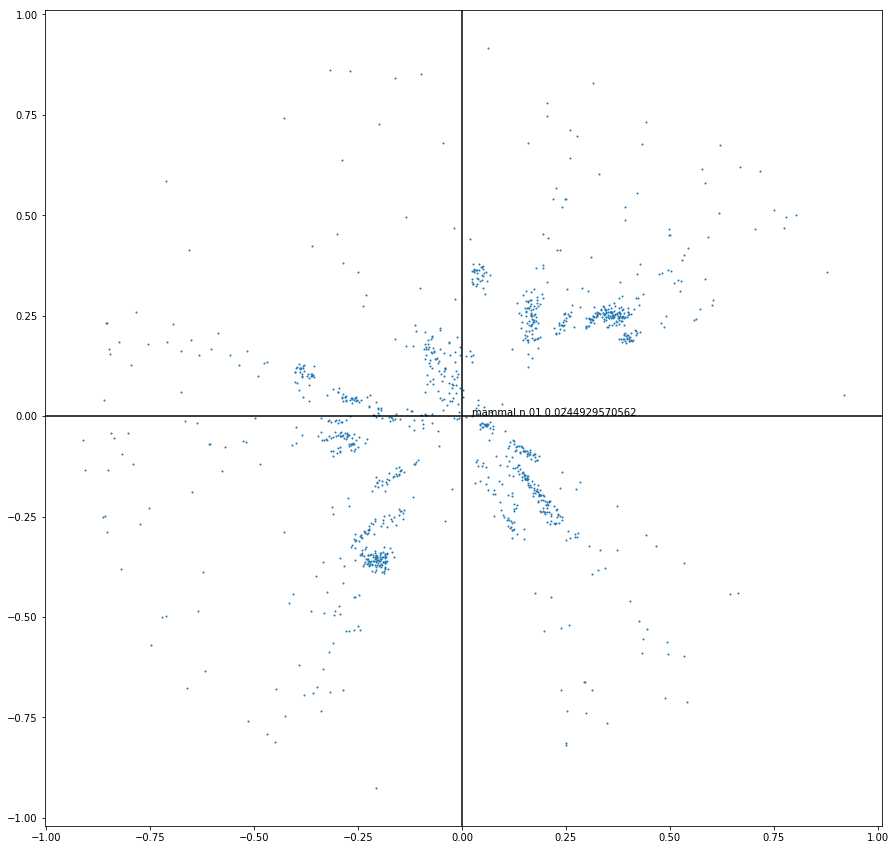

In [77]:
fig=plt.figure(figsize=(15,15))
names = []
positions_x = []
positions_y = []
for key in emb:
    names.append(key)
    positions_x.append(emb[key][0])
    positions_y.append(emb[key][1])

plt.scatter(positions_x,positions_y, s=1)
k=1
plt.text(positions_x[k], positions_y[k], names[k] + " " + str(positions_x[k]), fontsize=10)

circle = plt.Circle((0, 0), 1, color='g',fill=False)

plt.axis([-1,1,-1,1])
ax=fig.add_subplot(1,1,1)
ax.add_patch(circle)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title("Poincaré embeddings pour " + str(num_epochs) + " epochs, "
          + str(num_negs) + " negatifs, " 
         + str(nb_burn_in) + " périodes de burn-in")

plt.show()

### 2.2 Word Reconstruction

In [148]:
def evaluate_mean_rank_and_map(vocab, network, embeddings, max_n=None):
    """Evalue le mean rank et le MAP pour la reconstruction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(vocab, start=0)):
        if item not in network or item == "mammal.n.01":
            continue
        item_relations = []
        temp = list(embeddings.keys())
        for relation in network[item]:
            item_relations.append(temp.index(relation))
            
        item_distances = all_distances_to(item, embeddings)
#         print("item", item)
        positive_relation_ranks, avg_precision = \
            get_positive_relation_ranks_and_avg_prec(item_distances, item_relations)
        ranks += positive_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

def all_distances_to(item, embeddings):
    """Retourne une liste des distances d'un mot avec tous les autres"""
    all_distances=np.zeros(len(list(embeddings.keys())))
    
    for i, elem in list(enumerate(embeddings)):
        gamma = compute_gamma(embeddings[item], embeddings[elem])
        distance = poincare_dist(gamma)
        all_distances[i]=distance
    return all_distances
    
def get_positive_relation_ranks_and_avg_prec(all_distances, positive_relations):
    positive_relation_distances = all_distances[positive_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
    negative_relation_distances.mask[positive_relations] = True
    # Compute how many negative relation distances are less than each positive relation distance, plus 1 for rank
    ranks = (negative_relation_distances < positive_relation_distances[:, np.newaxis]).sum(axis=1) + 1
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
    return list(ranks), avg_precision

In [149]:
mean_rank, map_ = evaluate_mean_rank_and_map(vocab, network, emb)

In [150]:
print('WordNet reconstruction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

WordNet reconstruction
Paramètres :
Période de burn-in = 10
Epochs = 250
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 5
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 730.00794864 
MAP = 0.0127344795675


### 2.3 Link Prediction

In [180]:
def get_root_and_leaf_nodes(data_file):
    """Return keys of root and leaf nodes from a file with transitive closure relations"""
    root_candidates = set()
    leaf_candidates = set()
    with open(data_file, 'rb') as f:
        for line in f:
            nodes = line.split()
            root_candidates.update(nodes)
            leaf_candidates.update(nodes)
    
    with open(data_file, 'rb') as f:
        for line in f:
            node_1, node_2 = line.split()
            if node_1 == node_2:
                continue
            leaf_candidates.discard(node_1)
            root_candidates.discard(node_2)
    
    return (leaf_candidates, root_candidates)

In [179]:
def train_test_split(data_file, test_ratio=0.1):
    train_filename = data_file + '.train'
    test_filename = data_file + '.test'
    if os.path.exists(train_filename) and os.path.exists(test_filename):
        return (train_filename, test_filename)
    root_nodes, leaf_nodes = get_root_and_leaf_nodes(data_file)
    test_line_candidates = []
    line_count = 0
    all_nodes = set()
    with open(data_file, 'rb') as f:
        for i, line in list(enumerate(f)):
            node_1, node_2 = line.split()
            all_nodes.update([node_1, node_2])
            if (
                    node_1 not in leaf_nodes
                    and node_2 not in leaf_nodes
                    and node_1 not in root_nodes
                    and node_2 not in root_nodes
                    and node_1 != node_2
                ):
                test_line_candidates.append(i)
            line_count += 1

    num_test_lines = int(test_ratio * line_count)
    test_line_indices = set(random.sample(test_line_candidates, num_test_lines))
    train_line_indices = set(l for l in range(line_count) if l not in test_line_indices)
    
    train_set_nodes = set()
    with open(data_file, 'rb') as f:
        train_file = open(train_filename, 'wb')
        test_file = open(test_filename, 'wb')
        for i, line in list(enumerate(f)):
            if i in train_line_indices:
                train_set_nodes.update(line.split())
                train_file.write(line)
            elif i in test_line_indices:
                test_file.write(line)
        train_file.close()
        test_file.close()
    assert len(train_set_nodes) == len(all_nodes), 'Not all nodes from dataset present in train set relations'
    return (train_filename, test_filename)

In [167]:
def get_unknown_relation_ranks_and_avg_prec(all_distances, unknown_relations, known_relations):
    unknown_relation_distances = all_distances[unknown_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
    negative_relation_distances.mask[unknown_relations] = True
    negative_relation_distances.mask[known_relations] = True
    # Compute how many negative relation distances are less than each unknown relation distance, plus 1 for rank
    ranks = (negative_relation_distances < unknown_relation_distances[:, np.newaxis]).sum(axis=1) + 1
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
    return list(ranks), avg_precision

In [173]:
def evaluate_mean_rank_and_map_prediction(vocab, embeddings, items, relations, max_n=None):
    """Evaluate mean rank and MAP for link prediction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(items, start=0)):
        if item not in relations['unknown'] or item == "mammal.n.01":  # No positive relations to predict for this node
            continue
        unknown_relations = []
        for elem in list(relations['unknown'][item]):
            unknown_relations.append(vocab.index(elem))
        known_relations = []
        for elem in list(relations['known'][item]):
            known_relations.append(vocab.index(elem))
        
        item_distances = all_distances_to(item, embeddings)
        unknown_relation_ranks, avg_precision = \
            get_unknown_relation_ranks_and_avg_prec(item_distances, unknown_relations, known_relations)
        ranks += unknown_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

In [174]:
train_filename, test_filename = train_test_split('data/wordnet_mammal_hypernyms.tsv', test_ratio=0.1)

Train and test files already exist, skipping


In [175]:
relations = {'known': defaultdict(set), 'unknown': defaultdict(set)}
data_files = {'known': train_filename, 'unknown': test_filename}

In [176]:
items = set()
for relation_type, data_file in data_files.items():
    with open(data_file, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            relations[relation_type][row[0]].add(row[1])
            items.update([row[0], row[1]])

In [177]:
mean_rank, map_ = evaluate_mean_rank_and_map_prediction(vocab, network, emb, items, relations)

unknown_relations [13]
unknown_relations [7]
unknown_relations [7, 83, 111]
unknown_relations [166, 73, 167]
unknown_relations [9, 8, 7, 4]
unknown_relations [174, 7]
unknown_relations [63, 7, 62]
unknown_relations [17, 7]
unknown_relations [15, 18]
unknown_relations [13, 7]
unknown_relations [0]
unknown_relations [100, 56, 54, 55]
unknown_relations [17, 7]
unknown_relations [63]
unknown_relations [9, 7, 27, 25]
unknown_relations [17]
unknown_relations [13]
unknown_relations [0, 2, 484]
unknown_relations [0]
unknown_relations [15, 18, 7]
unknown_relations [55]
unknown_relations [7, 55]
unknown_relations [7, 5, 8, 30, 4, 9]
unknown_relations [18, 15, 7]
unknown_relations [17, 7]
unknown_relations [126, 17]
unknown_relations [18, 15, 17]
unknown_relations [7]
unknown_relations [17, 7, 42, 15, 18]
unknown_relations [4, 9, 5]
unknown_relations [56, 7, 55]
unknown_relations [17, 7]
unknown_relations [17, 7, 15, 18, 20]
unknown_relations [127, 17, 7]
unknown_relations [7]
unknown_relations [

In [178]:
print('Link prediction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

Link prediction
Paramètres :
Période de burn-in = 10
Epochs = 250
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 5
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 786.081606218 
MAP = 0.0258928786389
